In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Append the parent directory to sys.path
sys.path.append(parent_dir)

# Verify that the parent directory was added
print(sys.path[-1])

/home/yuki/quant_project/EURUSD-LSTM-prediction


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import *
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("../Data/USDJPY_Macro.csv")
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.dropna(inplace=True)
df_Macro.drop(columns=['CPI YOY Index','JNCPIYOY Index'],inplace=True)

df_Macro.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'USDJPYV1W Curncy',
       'USDJPYV1M Curncy', 'USDJPYV1Y Curncy', 'USDJPYVON Curncy',
       'JPYON Curncy', 'JPY1M Curncy', 'JPY12M Curncy', 'DXY Curncy',
       'GOLDS Comdty', 'CL1 Comdty', 'FEDL01 Index', 'USGG2YR Index',
       'USGG10YR Index', 'USGG30YR Index', 'GJGB2 Index', 'GJGB10 Index',
       'GJGB30 Index', 'SPX Index', 'VIX Index', 'NKY Index', 'Last_Return',
       'Predict_Return'],
      dtype='object')

In [3]:
split_point = int(df_Macro.shape[0]*0.9)
df_train = df_Macro.iloc[:split_point,:]
df_test = df_Macro.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)

# You can set this threshold manually
# threshold = 0.002

0.001908


In [4]:
y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = test_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

183
186
251


In [5]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':2,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.5}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()

def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()

    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    print(f"test loss is {test_loss}")
        
  return [loss_train, loss_test]   



def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")

    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
    
  return loss_ls

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [6]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 50
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.1786425465663923
test loss is 1.2093437809589431
-----------------------Epoch: 2----------------------------------
train loss is 1.1458509653257316
test loss is 1.196833781144628
-----------------------Epoch: 3----------------------------------
train loss is 1.1348313525891829
test loss is 1.1780075780364536
-----------------------Epoch: 4----------------------------------
train loss is 1.1279241532167141
test loss is 1.1554960001639556
-----------------------Epoch: 5----------------------------------
train loss is 1.119249733793424
test loss is 1.152577125710322
-----------------------Epoch: 6----------------------------------
train loss is 1.1139877870019048
test loss is 1.152812797289545
-----------------------Epoch: 7----------------------------------
train loss is 1.1029705106227166
test loss is 1.1295386320841436
-----------------------Epoch: 8----------------------------------
train loss is 1.09941

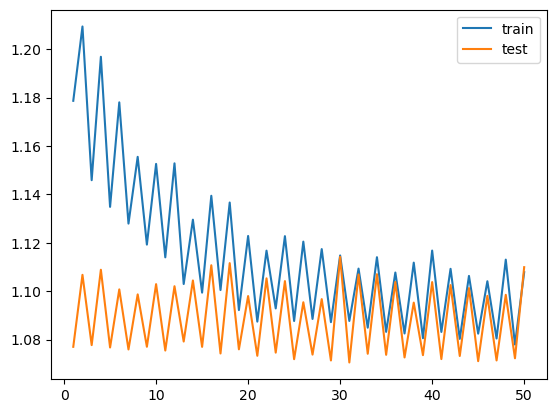

In [7]:
import matplotlib.pyplot as plt

loss_array = np.array(loss_ls).reshape((2,epochs))

plt.plot(range(1,len(loss_array[0])+1),loss_array[0],label = "train")
plt.plot(range(1,len(loss_array[1])+1),loss_array[1],label= "test")
plt.legend()
plt.show()

In [8]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))
net_test.eval()

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.33225806451612905

In [14]:
act_predict_bool = (predict_results != 1) & (predict_probability > 0.38)

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)

0.5714285714285714

In [15]:
act_predict_results.shape

torch.Size([14])

In [16]:
# saved_path = "../trained_model/USDJPY_Mac_LSTM.pth"

# torch.save(net_test.state_dict(),saved_path )